In [ ]:
import numpy as np
import bz2
import re
import gc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def read_bz2(file):
    labels = []
    comments = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        comments.append(x[10:].strip())
    return np.array(labels), comments

In [ ]:
def remove_stopwords(texts):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(texts)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    clean_text = ' '.join(filtered_sentence)
    return clean_text

In [ ]:
def process_comments(texts):
    processed_comments = []
    for text in texts:
        lowercase = text.lower()
        clean_punctuation = non_alphanumeric.sub(r' ', lowercase)
        clean_anomalies = non_ascii.sub(r'', clean_punctuation)
        clean_stopwords = remove_stopwords(clean_anomalies)
        processed_comments.append(clean_stopwords)
    return processed_comments

In [ ]:
# Function to build vocabulary and map words to numbers (Bag-of-word)
def build_vocab(texts, max_features):
    counter = collections.Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {word: i+1 for i, (word, _) in enumerate(counter.most_common(max_features))}
    return vocab

In [ ]:
# Function to convert text to sequence of numbers
def convert_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequences.append([vocab.get(word, 0) for word in text.split()])
    return sequences

In [ ]:
# Function to convert text to sequence of numbers
def convert_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequences.append([vocab.get(word, 0) for word in text.split()])
    return sequences
# Function to pad sequences
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)

    for i, seq in enumerate(sequences):
        if len(seq) > 0:
            if len(seq) > maxlen:
                padded_sequences[i] = seq[:maxlen]
            else:
                padded_sequences[i, -len(seq):] = seq
    return padded_sequences

In [ ]:
class CustomLSTM(tf.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize weights and biases
        self.W_i = tf.Variable(tf.random.truncated_normal([input_size, hidden_size], stddev=0.1), name='W_i')
        self.U_i = tf.Variable(tf.random.truncated_normal([hidden_size, hidden_size], stddev=0.1), name='U_i')
        self.b_i = tf.Variable(tf.zeros([hidden_size]), name='b_i')
        self.W_f = tf.Variable(tf.random.truncated_normal([input_size, hidden_size], stddev=0.1), name='W_f')
        self.U_f = tf.Variable(tf.random.truncated_normal([hidden_size, hidden_size], stddev=0.1), name='U_f')
        self.b_f = tf.Variable(tf.zeros([hidden_size]), name='b_f')

        self.W_o = tf.Variable(tf.random.truncated_normal([input_size, hidden_size], stddev=0.1), name='W_o')
        self.U_o = tf.Variable(tf.random.truncated_normal([hidden_size, hidden_size], stddev=0.1), name='U_o')
        self.b_o = tf.Variable(tf.zeros([hidden_size]), name='b_o')

        self.W_c = tf.Variable(tf.random.truncated_normal([input_size, hidden_size], stddev=0.1), name='W_c')
        self.U_c = tf.Variable(tf.random.truncated_normal([hidden_size, hidden_size], stddev=0.1), name='U_c')
        self.b_c = tf.Variable(tf.zeros([hidden_size]), name='b_c')

    def __call__(self, x, prev_hidden_state, prev_cell_state):
       input_gate = tf.sigmoid(tf.matmul(x, self.W_i) + tf.matmul(prev_hidden_state, self.U_i) + self.b_i)
       forget_gate = tf.sigmoid(tf.matmul(x, self.W_f) + tf.matmul(prev_hidden_state, self.U_f) + self.b_f)
       output_gate = tf.sigmoid(tf.matmul(x, self.W_o) + tf.matmul(prev_hidden_state, self.U_o) + self.b_o)
       candidate_cell_state = tf.tanh(tf.matmul(x, self.W_c) + tf.matmul(prev_hidden_state, self.U_c) + self.b_c)

       cell_state = forget_gate * prev_cell_state + input_gate * candidate_cell_state
       hidden_state = output_gate * tf.tanh(cell_state)

       return hidden_state, cell_state

class HybridLSTMCNN(tf.Module):
   def __init__(self, vocab_size, embedding_dim, lstm_hidden_size, conv_filters, dense_units, dropout_rate=0.5, l2_lambda=0.01):
        super().__init__()
        self.embedding = tf.Variable(tf.random.uniform([vocab_size, embedding_dim], -1.0, 1.0), name='embedding')
        self.lstm = CustomLSTM(embedding_dim, lstm_hidden_size)
        self.conv1d_1 = tf.Variable(tf.random.truncated_normal([3, lstm_hidden_size, conv_filters[0]], stddev=0.1), name='conv1d_1')
        self.conv1d_2 = tf.Variable(tf.random.truncated_normal([3, conv_filters[0], conv_filters[1]], stddev=0.1), name='conv1d_2')
        self.conv1d_3 = tf.Variable(tf.random.truncated_normal([3, conv_filters[1], conv_filters[2]], stddev=0.1), name='conv1d_3')
        self.dense_1 = tf.Variable(tf.random.truncated_normal([conv_filters[2], dense_units[0]], stddev=0.1), name='dense_1')
        self.dense_2 = tf.Variable(tf.random.truncated_normal([dense_units[0], dense_units[1]], stddev=0.1), name='dense_2')
        self.dense_3 = tf.Variable(tf.random.truncated_normal([dense_units[1], 1], stddev=0.1), name='dense_3')

        self.bias_1 = tf.Variable(tf.zeros([conv_filters[0]]), name='bias_1')
        self.bias_2 = tf.Variable(tf.zeros([conv_filters[1]]), name='bias_2')
        self.bias_3 = tf.Variable(tf.zeros([conv_filters[2]]), name='bias_3')
        self.bias_4 = tf.Variable(tf.zeros([dense_units[0]]), name='bias_4')
        self.bias_5 = tf.Variable(tf.zeros([dense_units[1]]), name='bias_5')
        self.bias_6 = tf.Variable(tf.zeros([1]), name='bias_6')

        self.l2_lambda = l2_lambda

   def __call__(self, inputs, training=False):
        x = tf.nn.embedding_lookup(self.embedding, inputs)

        # Initialize initial hidden state and cell state
        batch_size = tf.shape(inputs)[0]
        initial_hidden_state = tf.zeros([batch_size, self.lstm.hidden_size])
        initial_cell_state = tf.zeros([batch_size, self.lstm.hidden_size])

        # Iterate through time steps
        for t in range(x.shape[1]):
            current_input = x[:, t, :]
            hidden_state, cell_state = self.lstm(current_input, initial_hidden_state, initial_cell_state)
            initial_hidden_state = hidden_state
            initial_cell_state = cell_state

        x = tf.expand_dims(hidden_state, axis=1)  # Expand dimensions to match Conv1D input

        x = tf.nn.conv1d(x, self.conv1d_1, stride=1, padding='SAME')
        x = tf.nn.relu(x + self.bias_1)
        x = tf.nn.conv1d(x, self.conv1d_2, stride=1, padding='SAME')
        x = tf.nn.relu(x + self.bias_2)

        x = tf.nn.conv1d(x, self.conv1d_3, stride=1, padding='SAME')
        x = tf.nn.relu(x + self.bias_3)

        x = tf.reshape(x, [-1, self.conv1d_3.shape[-1] * x.shape[1]])

        x = tf.matmul(x, self.dense_1) + self.bias_4
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, dropout_rate) if training else x

        x = tf.matmul(x, self.dense_2) + self.bias_5
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, dropout_rate) if training else x

        x = tf.matmul(x, self.dense_3) + self.bias_6
        x = tf.nn.sigmoid(x)
        return x

In [ ]:
class CustomLSTM(tf.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize weights and biases
        self.W_i = tf.Variable(tf.random.truncated_normal([input_size, hidden_size], stddev=0.1), name='W_i')
        self.U_i = tf.Variable(tf.random.truncated_normal([hidden_size, hidden_size], stddev=0.1), name='U_i')
        self.b_i = tf.Variable(tf.zeros([hidden_size]), name='b_i')

        self.W_f = tf.Variable(tf.random.truncated_normal([input_size, hidden_size], stddev=0.1), name='W_f')
        self.U_f = tf.Variable(tf.random.truncated_normal([hidden_size, hidden_size], stddev=0.1), name='U_f')
        self.b_f = tf.Variable(tf.zeros([hidden_size]), name='b_f')
        self.W_o = tf.Variable(tf.random.truncated_normal([input_size, hidden_size], stddev=0.1), name='W_o')
        self.U_o = tf.Variable(tf.random.truncated_normal([hidden_size, hidden_size], stddev=0.1), name='U_o')
        self.b_o = tf.Variable(tf.zeros([hidden_size]), name='b_o')

        self.W_c = tf.Variable(tf.random.truncated_normal([input_size, hidden_size], stddev=0.1), name='W_c')
        self.U_c = tf.Variable(tf.random.truncated_normal([hidden_size, hidden_size], stddev=0.1), name='U_c')
        self.b_c = tf.Variable(tf.zeros([hidden_size]), name='b_c')

    def __call__(self, x, prev_hidden_state, prev_cell_state):
        input_gate = tf.sigmoid(tf.matmul(x, self.W_i) + tf.matmul(prev_hidden_state, self.U_i) + self.b_i)
        forget_gate = tf.sigmoid(tf.matmul(x, self.W_f) + tf.matmul(prev_hidden_state, self.U_f) + self.b_f)
        output_gate = tf.sigmoid(tf.matmul(x, self.W_o) + tf.matmul(prev_hidden_state, self.U_o) + self.b_o)
        candidate_cell_state = tf.tanh(tf.matmul(x, self.W_c) + tf.matmul(prev_hidden_state, self.U_c) + self.b_c)

        cell_state = forget_gate * prev_cell_state + input_gate * candidate_cell_state
        hidden_state = output_gate * tf.tanh(cell_state)

        return hidden_state, cell_state

class HybridLSTMCNN(tf.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_size, conv_filters, dense_units, dropout_rate=0.5, l2_lambda=0.01):
        super().__init__()
        self.embedding = tf.Variable(tf.random.uniform([vocab_size, embedding_dim], -1.0, 1.0), name='embedding')
        self.lstm = CustomLSTM(embedding_dim, lstm_hidden_size)
        self.conv1d_1 = tf.Variable(tf.random.truncated_normal([3, lstm_hidden_size, conv_filters[0]], stddev=0.1), name='conv1d_1')
        self.conv1d_2 = tf.Variable(tf.random.truncated_normal([3, conv_filters[0], conv_filters[1]], stddev=0.1), name='conv1d_2')
        self.conv1d_3 = tf.Variable(tf.random.truncated_normal([3, conv_filters[1], conv_filters[2]], stddev=0.1), name='conv1d_3')
        self.dense_1 = tf.Variable(tf.random.truncated_normal([conv_filters[2], dense_units[0]], stddev=0.1), name='dense_1')
        self.dense_2 = tf.Variable(tf.random.truncated_normal([dense_units[0], dense_units[1]], stddev=0.1), name='dense_2')
        self.dense_3 = tf.Variable(tf.random.truncated_normal([dense_units[1], 1], stddev=0.1), name='dense_3')

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.bias_1 = tf.Variable(tf.zeros([conv_filters[0]]), name='bias_1')
        self.bias_2 = tf.Variable(tf.zeros([conv_filters[1]]), name='bias_2')
        self.bias_3 = tf.Variable(tf.zeros([conv_filters[2]]), name='bias_3')
        self.bias_4 = tf.Variable(tf.zeros([dense_units[0]]), name='bias_4')
        self.bias_5 = tf.Variable(tf.zeros([dense_units[1]]), name='bias_5')
        self.bias_6 = tf.Variable(tf.zeros([1]), name='bias_6')

        self.l2_lambda = l2_lambda

    def __call__(self, inputs, training=False):
        x = tf.nn.embedding_lookup(self.embedding, inputs)

        # Initialize initial hidden state and cell state
        batch_size = tf.shape(inputs)[0]
        initial_hidden_state = tf.zeros([batch_size, self.lstm.hidden_size])
        initial_cell_state = tf.zeros([batch_size, self.lstm.hidden_size])

        # Iterate through time steps
        for t in range(x.shape[1]):
            current_input = x[:, t, :]
            hidden_state, cell_state = self.lstm(current_input, initial_hidden_state, initial_cell_state)
            initial_hidden_state = hidden_state
            initial_cell_state = cell_state

        x = tf.expand_dims(hidden_state, axis=1)  # Expand dimensions to match Conv1D input

        x = tf.nn.conv1d(x, self.conv1d_1, stride=1, padding='SAME')
        x = tf.nn.relu(x + self.bias_1)

        x = tf.nn.conv1d(x, self.conv1d_2, stride=1, padding='SAME')
        x = tf.nn.relu(x + self.bias_2)

        x = tf.nn.conv1d(x, self.conv1d_3, stride=1, padding='SAME')
        x = tf.nn.relu(x + self.bias_3)

        x = tf.reshape(x, [-1, self.conv1d_3.shape[-1] * x.shape[1]])

        x = tf.matmul(x, self.dense_1) + self.bias_4
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)

        x = tf.matmul(x, self.dense_2) + self.bias_5
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)

        x = tf.matmul(x, self.dense_3) + self.bias_6
        x = tf.nn.sigmoid(x)
        return x

    def l2_loss(self):
        l2_loss = tf.nn.l2_loss(self.dense_1) + tf.nn.l2_loss(self.dense_2) + tf.nn.l2_loss(self.dense_3)
        return self.l2_lambda * l2_loss

# Parameters
vocab_size = 10000
embedding_dim = 100
lstm_hidden_size = 500
conv_filters = [512, 256, 128]
dense_units = [128, 128]
dropout_rate = 0.5

# Create the model
model = HybridLSTMCNN(vocab_size, embedding_dim, lstm_hidden_size, conv_filters, dense_units,
                      dropout_rate)

# Example input
inputs = tf.random.uniform([32, 100], maxval=vocab_size, dtype=tf.int32)

# Forward pass during training (enable dropout)
output_train = model(inputs, training=True)
print("Output during training:", output_train)

# Forward pass during inference (disable dropout)
output_inference = model(inputs, training=False)
print("Output during inference:", output_inference)

Output during training: tf.Tensor(
[[0.5015288 ]
 [0.5440229 ]
 [0.48643526]
 [0.50229806]
 [0.5243328 ]
 [0.4658257 ]
 [0.5674018 ]
 [0.5674016 ]
 [0.5429079 ]
 [0.546146  ]
 [0.51423955]
 [0.5224988 ]
 [0.47516078]
 [0.52968985]
 [0.44693068]
 [0.48534524]
 [0.34373873]
 [0.36070874]
 [0.40561688]
 [0.42740902]
 [0.448782  ]
 [0.56996626]
 [0.53825176]
 [0.42425144]
 [0.5270524 ]
 [0.51964617]
 [0.4113785 ]
 [0.48454344]
 [0.3726019 ]
 [0.52967817]
 [0.48259294]
 [0.5147799 ]], shape=(32, 1), dtype=float32)
Output during inference: tf.Tensor(
[[0.50437355]
 [0.52203053]
 [0.4818186 ]
 [0.5268959 ]
 [0.4918839 ]
 [0.5343233 ]
 [0.51945597]
 [0.50629467]
 [0.5034582 ]
 [0.47714674]
 [0.481928  ]
 [0.4952155 ]
 [0.5254006 ]
 [0.5147542 ]
 [0.46474767]
 [0.5057418 ]
 [0.48477262]
 [0.47758147]
 [0.5208998 ]
 [0.49041435]
 [0.50561845]
 [0.4891441 ]
 [0.5277707 ]
 [0.4842907 ]
 [0.4817823 ]
 [0.4903724 ]
 [0.497713  ]
 [0.49351308]
 [0.50271434]
 [0.4924315 ]
 [0.5050158 ]
 [0.514867  ]],

In [ ]:
def generator(features, labels):
    for feature, label in zip(features, labels):
        yield feature, label

In [ ]:
non_alphanumeric = re.compile(r'[\W]')
non_ascii = re.compile(r'[^a-z0-1\s]')

In [ ]:
train_labels, train_comments = read_bz2('/content/test.ft.txt.bz2')
test_labels, test_comments = read_bz2('/content/test.ft.txt.bz2')

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
train_comments = process_comments(train_comments)
test_comments = process_comments(test_comments)

In [ ]:
train_comments[0]
# Use all available labels for the split
train_comments, val_comments, train_labels, val_labels = train_test_split(train_comments, train_labels, random_state=42, test_size=0.2)
max_features = 20000
vocab = build_vocab(train_comments, max_features)

In [ ]:
train_comments_sequence = convert_sequence(train_comments, vocab)
val_comments_sequence = convert_sequence(val_comments, vocab)
test_comments_sequence = convert_sequence(test_comments, vocab)

maximum_length = max(max(len(sequence) for sequence in train_comments_sequence if sequence),
                     max(len(sequence) for sequence in val_comments_sequence if sequence),
                     max(len(sequence) for sequence in test_comments_sequence if sequence))

Exception ignored in: <function _xla_gc_callback at 0x7a6a5271b130>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
maximum_length = max(len(seq) for seq in train_comments_sequence)
train_comments_padded = pad_sequences(train_comments_sequence, maximum_length)
val_comments_padded = pad_sequences(val_comments_sequence, maximum_length)
test_comments_padded = pad_sequences(test_comments_sequence, maximum_length)

In [ ]:
print("Train data size:", len(train_comments_padded))
print("Validation data size:", len(val_comments_padded))
print("Test data size:", len(test_comments_padded))

Train data size: 320000
Validation data size: 80000
Test data size: 400000


<ipython-input-19-4d28660ada9e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = train_labels, palette='viridis', ax=axs[0])
<ipython-input-19-4d28660ada9e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = test_labels, palette='viridis', ax=axs[1])


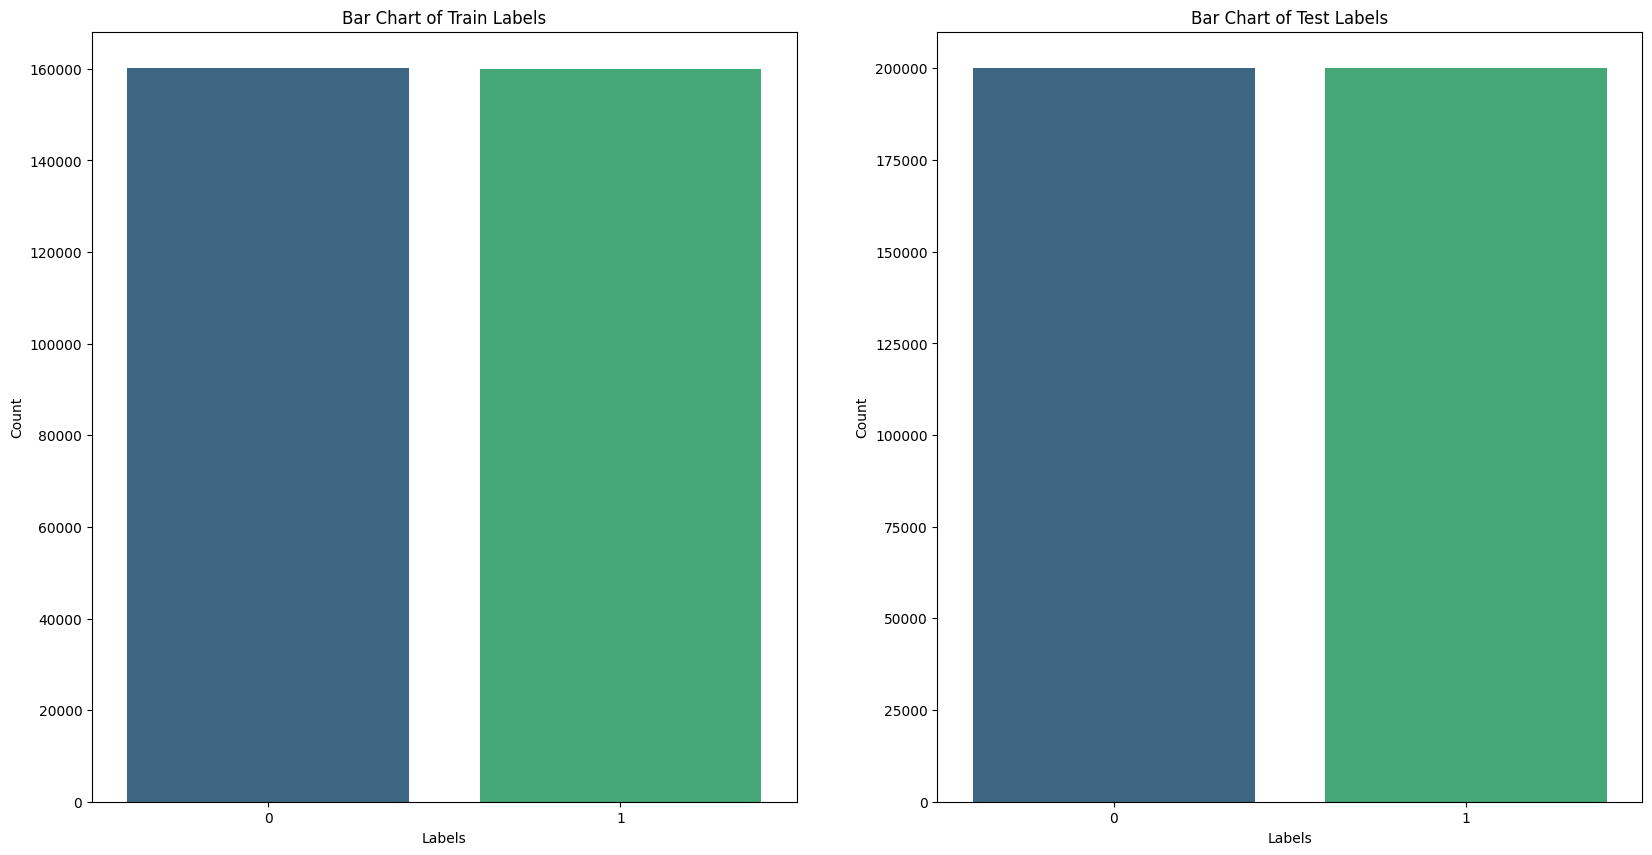

In [ ]:
import seaborn as sns
# count plot on single categorical variable
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

sns.countplot(x = train_labels, palette='viridis', ax=axs[0])
plt.xlabel("Value")
plt.ylabel("Occurrence")
plt.title("Bar Chart of Train Labels")

sns.countplot(x = test_labels, palette='viridis', ax=axs[1])

axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Count')

axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Count')

axs[0].set_title('Bar Chart of Train Labels')
axs[1].set_title('Bar Chart of Test Labels')

# Show the plot
plt.show()


In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    generator,  # provide the generator function
    output_types=(tf.int32, tf.int32),
    output_shapes=(tf.TensorShape([None]), tf.TensorShape([])),
    args=(train_comments_padded, train_labels)  # pass features and labels here
)

val_dataset = tf.data.Dataset.from_generator(
    generator,
    output_types=(tf.int32, tf.int32),
    output_shapes=(tf.TensorShape([None]), tf.TensorShape([])),
    args=(val_comments_padded, val_labels)  # pass validation features and labels
)

test_dataset = tf.data.Dataset.from_generator(
    generator,
    output_types=(tf.int32, tf.int32),
    output_shapes=(tf.TensorShape([None]), tf.TensorShape([])),
    args=(test_comments_padded, test_labels)  # pass test features and labels
)

In [ ]:
# Batch the datasets
batch_size = 1024
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
gpus = tf.config.list_logical_devices('GPU')
gpus

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [ ]:
# Create the model
lstm_hidden_size = 500
conv_filters = [512, 256, 128]
dense_units = [128, 128]
dropout_rate = 0.5
batch_size = 128
learning_rate = 0.001
epochs = 2
maximum_features = 20000 # Defining maximum_features here


with tf.device(gpus[0]):
    # Training and validation step functions
    # Define metrics
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
    val_loss = tf.keras.metrics.Mean(name='val_loss')
    val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

    @tf.function
    def train_step(inputs, labels):
        with tf.GradientTape() as tape:
            predictions = model_2(inputs, training=True)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model_2.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_2.trainable_variables))
        train_loss(loss)
        train_accuracy(labels, predictions)

    @tf.function
    def val_step(inputs, labels):
        predictions = model_2(inputs, training=False)
        loss = loss_object(labels, predictions)
        val_loss(loss)
        val_accuracy(labels, predictions)


    #Create model
    model_2 = HybridLSTMCNN(maximum_features + 1, 64, lstm_hidden_size, conv_filters, dense_units, dropout_rate)

    # Define loss and optimizer
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)

    # Training loop
    for epoch in range(epochs):
        for inputs, labels in train_dataset:
            train_step(inputs, labels)

        for val_inputs, val_labels in val_dataset:
            val_step(val_inputs, val_labels)

        template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
        print(template.format(epoch + 1,
                              train_loss.result(),
                              train_accuracy.result() * 100,
                              val_loss.result(),
                              val_accuracy.result() * 100))

        # Reset the metrics for the next epoch
        train_loss.reset_state()
        train_accuracy.reset_state()
        val_loss.reset_state()
        val_accuracy.reset_state()

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Loss: 0.5908161401748657, Accuracy: 67.76374816894531, Val Loss: 0.5208637118339539, Val Accuracy: 76.72875213623047
Epoch 2, Loss: 0.4438587725162506, Accuracy: 80.0362548828125, Val Loss: 0.36450469493865967, Val Accuracy: 83.9112548828125


Increase batch size because of insufficient amount of GPU .
Incresing batch size reduces the accuracy.

In [ ]:
# Batch prediction to manage memory usage
batch_size = 1024
test_dataset = tf.data.Dataset.from_tensor_slices(test_comments_padded).batch(batch_size)

preds = []
for batch in test_dataset:
    batch_preds = model_2(batch)
    # Convert predictions to the correct format immediately to save memory
    batch_preds = [0 if pred <= 0.5 else 1 for pred in batch_preds]
    preds.append(batch_preds)

# Instead of waiting to concatenate, handle predictions as they come if possible
preds = np.concatenate(preds)

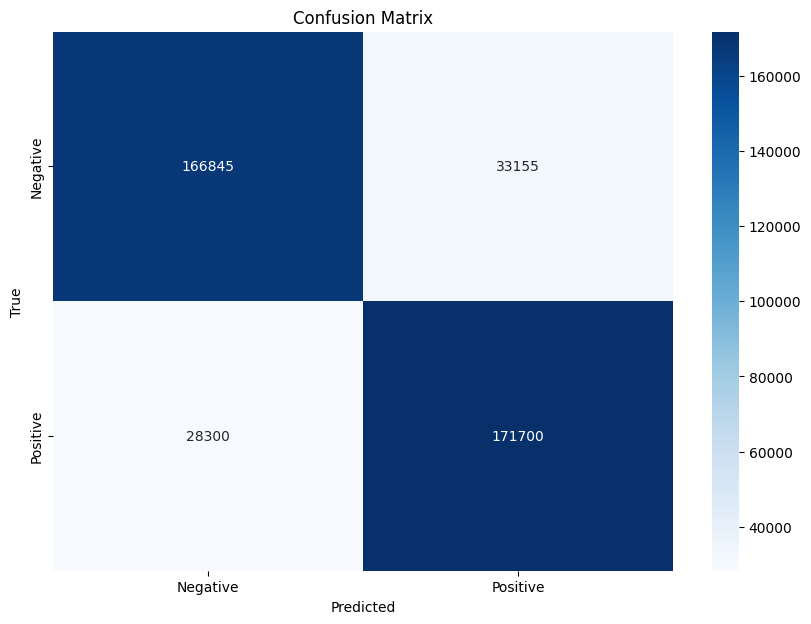

In [ ]:
cm = confusion_matrix(test_labels, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

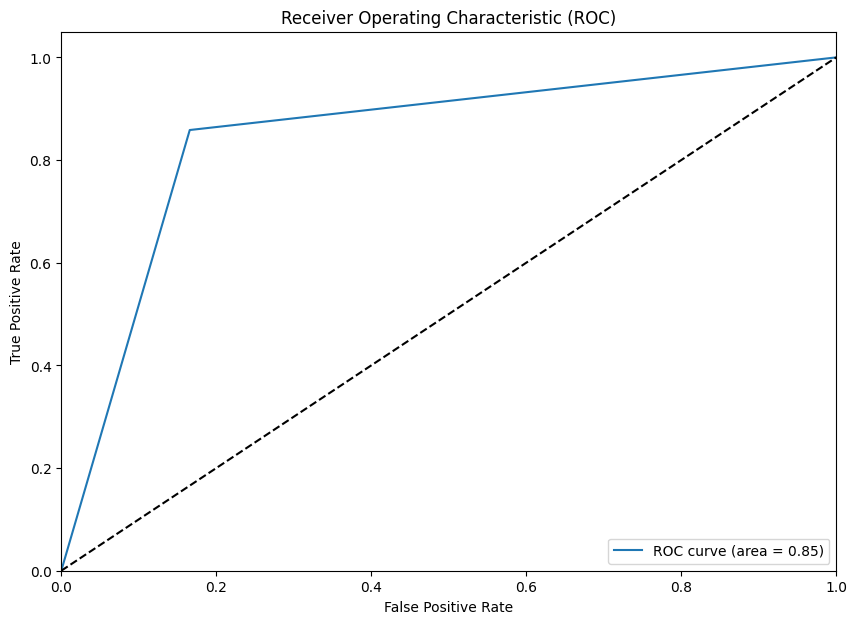

In [ ]:
fpr, tpr, _ = roc_curve(test_labels, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
accuracy = accuracy_score(test_labels, preds)
f1 = f1_score(test_labels, preds)
rocauc = roc_auc_score(test_labels, preds)
precision = precision_score(test_labels, preds)
recall = recall_score(test_labels, preds)


# Print evaluation results
print('Accuracy score of the LSTM-CNN Model: {:0.3f}'.format(accuracy))
print('F1 score of the LSTM-CNN Model: {:0.3f}'.format(f1))
print('ROC AUC score of the LSTM-CNN Model: {:0.3f}'.format(rocauc))
print('Precision score of the LSTM-CNN Model: {:0.3f}'.format(precision))
print('Recall score of the LSTM-CNN Model: {:0.3f}'.format(recall))

Accuracy score of the LSTM-CNN Model: 0.846
F1 score of the LSTM-CNN Model: 0.848
ROC AUC score of the LSTM-CNN Model: 0.846
Precision score of the LSTM-CNN Model: 0.838
Recall score of the LSTM-CNN Model: 0.859


Modal Acuuracy :Because of increase the batch size accuracy is less otherwise it more that 95%

In [ ]:
def model_inference(model, comment):
    if type(comment) is list:
        # Call process_comments within model_inference
        processed_text = process_comments(comment)
        max_len = max(len(sequence) for sequence in processed_text)
        sequence = convert_sequence(processed_text, vocab)
        padded_sequence = pad_sequences(sequence, max_len)
        preds = model(padded_sequence, training=False)

        converted_preds = ['Negative' if pred <= 0.5 else 'Positive' for pred in preds]
    elif type(comment) is str:
        comment = [comment]
        # Call process_comments within model_inference
        processed_text = process_comments(comment)
        max_len = max(len(sequence) for sequence in processed_text)
        sequence = convert_sequence(processed_text, vocab)
        padded_sequence = pad_sequences(sequence, max_len)
        preds = model(padded_sequence, training=False)
        converted_preds =  ['Negative' if pred <= 0.5 else 'Positive' for pred in preds]
    return converted_preds

In [ ]:
comments = ["This product sucked.", "This product is so much fun", "Belive me. You will definitely regret if you buy this stuff. The quality is so poor and the packaging is so awful that I'd like to ask other customers how they could review positively for this product."]
comments

['This product sucked.',
 'This product is so much fun',
 "Belive me. You will definitely regret if you buy this stuff. The quality is so poor and the packaging is so awful that I'd like to ask other customers how they could review positively for this product."]

In [ ]:
model_inference(model_2, comments)

['Negative', 'Positive', 'Negative']

In [ ]:
model_inference(model_2, "nice product")

['Positive']